Switch detected at step 6133: A → B
Switch detected at step 6135: B → A
Switch detected at step 6139: A → B
Switch detected at step 6140: B → A
Switch detected at step 6141: A → B
Switch detected at step 6146: B → A
Switch detected at step 6151: A → B
Switch detected at step 6251: B → A
Switch detected at step 6253: A → B
Switch detected at step 6257: B → A
Switch detected at step 6278: A → B
Switch detected at step 6279: B → A
Switch detected at step 8909: A → B
Switch detected at step 25634: B → A
Switch detected at step 25635: A → B
Switch detected at step 25647: B → A
Switch detected at step 29819: A → B
Switch detected at step 29825: B → A
Switch detected at step 29829: A → B
Switch detected at step 29833: B → A
Switch detected at step 29834: A → B
Switch detected at step 29877: B → A
Switch detected at step 29893: A → B
Switch detected at step 29895: B → A
Switch detected at step 29897: A → B
Switch detected at step 80786: B → A
Switch detected at step 82969: A → B
Switch detecte

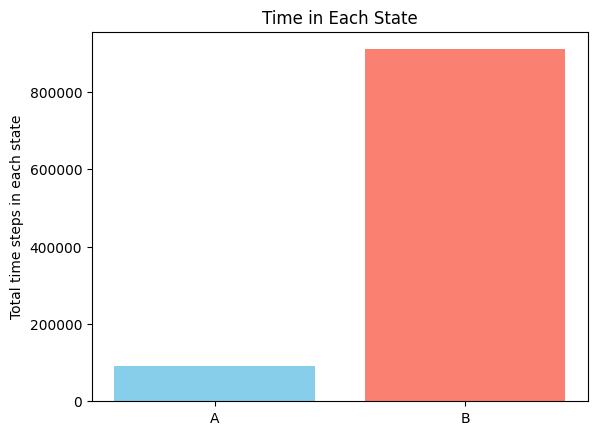

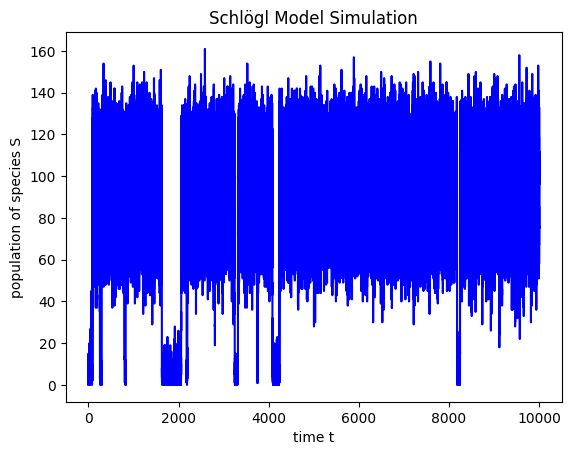


Largest eigenvalue (should be ~0): 6.658926446148555e-13
First 10 eigenvalues: [ 6.65892645e-13 -4.31319943e-03 -1.18136055e+00 -1.95563628e+00
 -2.91295749e+00 -3.90182788e+00 -5.07021394e+00 -6.44708467e+00
 -7.98346987e+00 -9.65961071e+00]
Stationary residual ||Q^T pi|| = 1.1013090963130918e-12


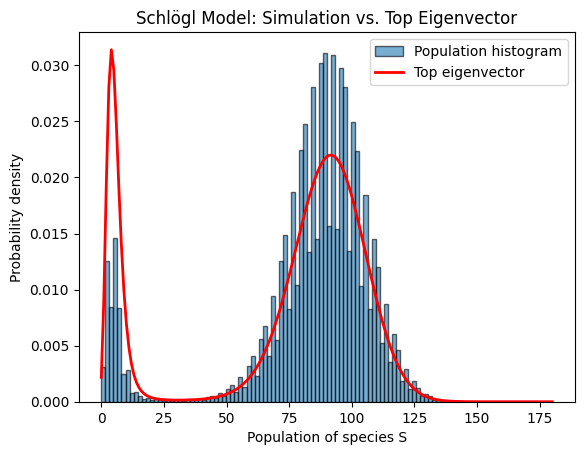

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %define physical constants
p = 1
q = 2
k1 = 3
k2 = 0.6
k3 = 0.25
k4 = 2.95
V = 25

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %define reaction rates
def lam1(i):  # rate A+2S->3S
    return p * k1 * i * (i - 1) / V

def lam2(i):  # rate 3S->A+2S
    return k2 * i * (i - 1) * (i - 2) / (V ** 2)

def lam3(i):  # rate B->S
    return q * k3 * V

def lam4(i):  # rate S->B
    return k4 * i

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %define simulation parameters
tau = 0.01      # time step
N = 10**6       # number of steps

# initialize population history
population = np.zeros(N, dtype=int)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %begin simulation of the Schlogl model (tau-leaping)

i = 0   # initial population
state_A_count = 0
state_B_count = 0
switches = 0

prev_state = 'A' if i < 30 else 'B'

for n in range(1, N):

    if n % int(1e5) == 0:
        print(f"percent complete = ...{100*n/N:.1f}%")

    # simulate increments/decrements
    i_inc = np.random.poisson(tau * (lam1(i) + lam3(i)))
    i_dec = np.random.poisson(tau * (lam2(i) + lam4(i)))
    i = max(i + i_inc - i_dec, 0)

    population[n] = i

    # determine state
    current_state = 'B' if i >= 30 else 'A'

    if current_state == 'A':
        state_A_count += 1
    else:
        state_B_count += 1

    if current_state != prev_state:
        switches += 1
        print(f"Switch detected at step {n}: {prev_state} → {current_state}")

    prev_state = current_state

print(f"\nTime steps in state A: {state_A_count}")
print(f"Time steps in state B: {state_B_count}")
print(f"Number of state switches: {switches}")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %plot bar chart of state times

fig, ax = plt.subplots()
states = ['A', 'B']
counts = [state_A_count, state_B_count]
ax.bar(states, counts, color=['skyblue', 'salmon'])
ax.set_ylabel('Total time steps in each state')
ax.set_title('Time in Each State')
plt.show()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %plot the population trajectory

plt.plot(np.arange(N) * tau, population, '-b')
plt.xlabel('time t')
plt.ylabel('population of species S')
plt.title('Schlögl Model Simulation')
plt.show()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %construct the rate matrix Q

M = 180   # cutoff for population
Q = np.zeros((M + 1, M + 1))

for i_val in range(0, M):
    Q[i_val, i_val + 1] = lam1(i_val) + lam3(i_val)
for i_val in range(1, M + 1):
    Q[i_val, i_val - 1] = lam2(i_val) + lam4(i_val)

Q = Q - np.diag(Q.sum(axis=1))


vals, vecs = np.linalg.eig(Q.T)
idx = np.argsort(vals)[::-1]   # sort descending
eig_vals = vals[idx]
eig_vecs = vecs[:, idx]

# normalize top eigenvector to probability distribution
eig_vecs[:, 0] = eig_vecs[:, 0].real
eig_vecs[:, 0] = eig_vecs[:, 0] / np.sum(eig_vecs[:, 0])

print("\nLargest eigenvalue (should be ~0):", eig_vals[0])
print("First 10 eigenvalues:", eig_vals[0:10])


fig, ax = plt.subplots()

# Histogram of simulation
ax.hist(population, bins=100, edgecolor='black', density=True,
        alpha=0.6, label='Population histogram')

# Scale eigenvector to density
eig_vec_plot_x = np.arange(0, M+1)
bin_width = eig_vec_plot_x[1] - eig_vec_plot_x[0]
eig_vec_density = eig_vecs[:, 0] / bin_width
ax.plot(eig_vec_plot_x, eig_vec_density, 'r-', lw=2, label='Top eigenvector')

ax.set_xlabel('Population of species S')
ax.set_ylabel('Probability density')
ax.set_title('Schlögl Model: Simulation vs. Top Eigenvector')
ax.legend()

plt.show()

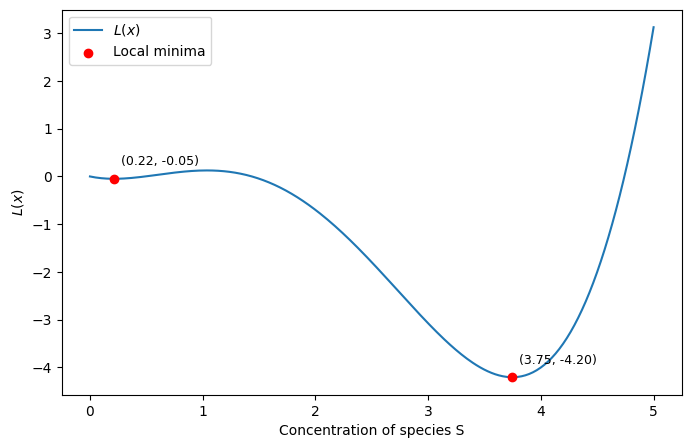

In [62]:
from scipy.signal import argrelextrema
x_start = 0
x_end = 5
domain = np.linspace(x_start, x_end, 300)

# Function definition
y_vals = -1/3*p*k1*(domain)**3 + 1/4*k2*(domain)**4 - k3*q*(domain) + 1/2*k4*(domain)**2

# Find local minima
min_indices = argrelextrema(y_vals, np.less)[0]

# Plot
plt.figure(figsize=(8,5))
plt.plot(domain, y_vals, label=r"$L(x)$")
plt.scatter(domain[min_indices], y_vals[min_indices], color="red", zorder=5, label="Local minima")

# Label each minimum
for i in min_indices:
    plt.annotate(
        f"({domain[i]:.2f}, {y_vals[i]:.2f})",
        (domain[i], y_vals[i]),
        textcoords="offset points",
        xytext=(5,10),  # shift text so it doesn’t overlap the point
        ha="left",
        fontsize=9,
        color="black"
    )

plt.xlabel("Concentration of species S")
plt.ylabel(r"$L(x)$")
plt.legend()
plt.show()

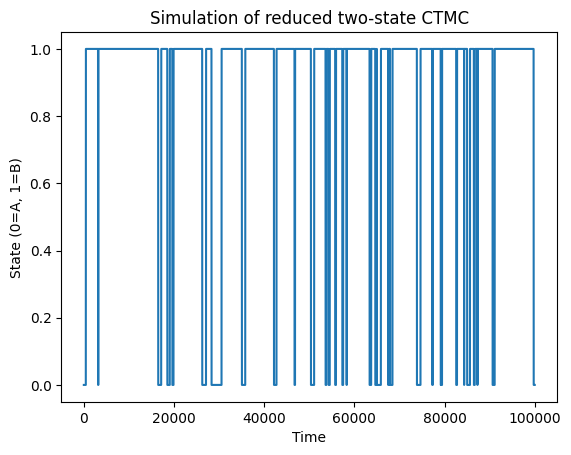

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k_AB = 1.82e-3
k_BA = 3.85e-4
T = 1e5
dt = 0.1
n_steps = int(T/dt)

# Initialize
state = np.zeros(n_steps)
current = 0  # start in State A

for t in range(1, n_steps):
    if current == 0 and np.random.rand() < k_AB * dt:
        current = 1
    elif current == 1 and np.random.rand() < k_BA * dt:
        current = 0
    state[t] = current

plt.plot(np.arange(n_steps)*dt, state)
plt.xlabel('Time')
plt.ylabel('State (0=A, 1=B)')
plt.title('Simulation of reduced two-state CTMC')
plt.show()

Reduced rates from eigenvectors:
k_AB = 0.0033469516934692338
k_BA = 0.0009662477395587748


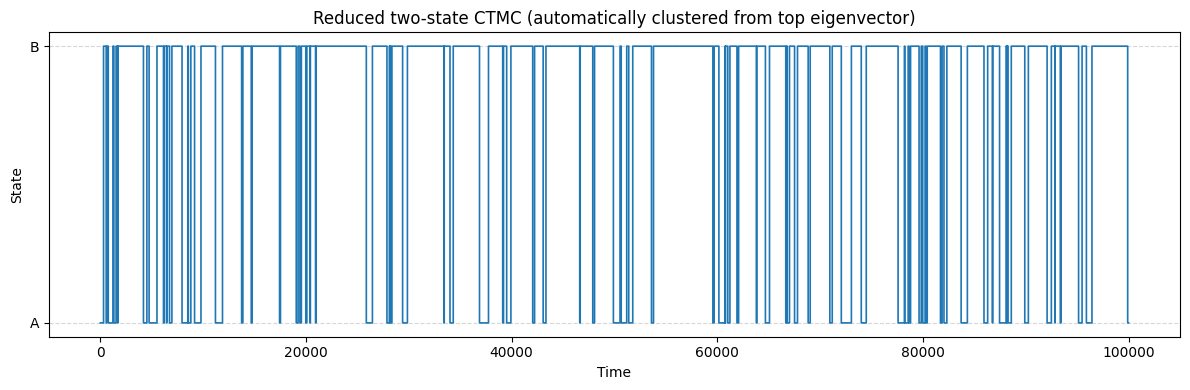

In [80]:
from sklearn.cluster import KMeans
eigvals, eigvecs = np.linalg.eig(Q.T)
eigvals = eigvals.real
eigvecs = eigvecs.real

# Sort eigenvalues descending
idx = np.argsort(-eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

v1 = eigvecs[:, 0]          # top eigenvector (stationary distribution)
lambda2 = eigvals[1]        # second eigenvalue (slowest nonzero mode)

# ----------------------------
# Cluster microstates into two metastable states (A and B)
# ----------------------------
v1_reshaped = v1.reshape(-1, 1)  # KMeans needs 2D input
kmeans = KMeans(n_clusters=2, random_state=42).fit(v1_reshaped)
labels = kmeans.labels_

# Assign microstates to A and B
A_idx = np.where(labels == 0)[0]
B_idx = np.where(labels == 1)[0]

# ----------------------------
# Compute stationary probabilities for A and B
# ----------------------------
pi_A = np.sum(v1[A_idx])
pi_B = np.sum(v1[B_idx])

# Compute reduced CTMC rates
k_AB = -lambda2 * pi_B / (pi_A + pi_B)
k_BA = -lambda2 * pi_A / (pi_A + pi_B)

print("Reduced rates from eigenvectors:")
print("k_AB =", k_AB)
print("k_BA =", k_BA)

# ----------------------------
# Simulate reduced two-state CTMC
# ----------------------------
T = 1e5
dt = 0.1
n_steps = int(T / dt)

state = np.zeros(n_steps)
current = 0  # start in State A

for t in range(1, n_steps):
    if current == 0 and np.random.rand() < k_AB * dt:
        current = 1
    elif current == 1 and np.random.rand() < k_BA * dt:
        current = 0
    state[t] = current

# ----------------------------
# Plot simulation
# ----------------------------
plt.figure(figsize=(12,4))
plt.step(np.arange(n_steps)*dt, state, where='post', lw=1.2)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Reduced two-state CTMC (from top eigenvector)')
plt.yticks([0,1], ['A','B'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

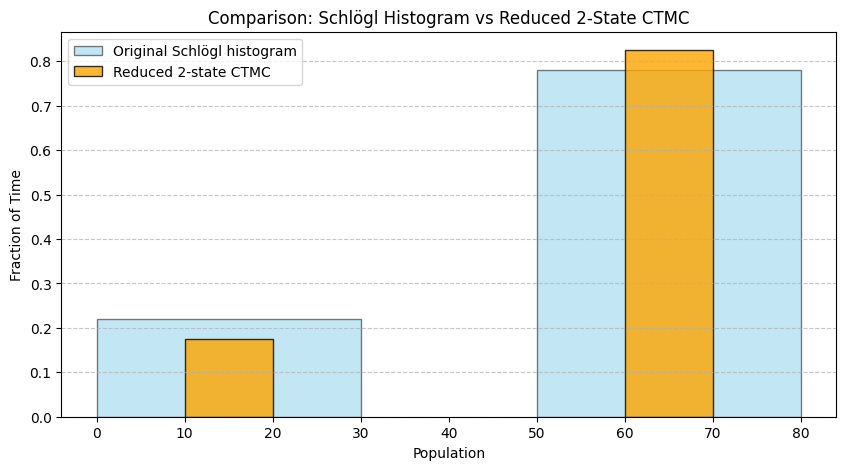

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Original Schlögl histogram (example data)
# Suppose the histogram has population bins 0-30 (State A) and 30-100 (State B)
population_bins = [0, 30, 100]
hist_counts = [220000, 780000]  # total time steps in each state
hist_fraction = np.array(hist_counts)/np.sum(hist_counts)

# Reduced CTMC stationary distribution
k_AB = 1.82e-3
k_BA = 3.85e-4

pi_A = k_BA / (k_AB + k_BA)
pi_B = k_AB / (k_AB + k_BA)

ctmc_fraction = [pi_A, pi_B]

# Midpoints for plotting CTMC histogram
midpoints = [(population_bins[i]+population_bins[i+1])/2 for i in range(len(population_bins)-1)]

# Plot original histogram
plt.figure(figsize=(10,5))
plt.bar([15, 65], hist_fraction, width=30, alpha=0.5, label='Original Schlögl histogram', color='skyblue', edgecolor='black')

# Overlay CTMC stationary distribution
plt.bar(midpoints, ctmc_fraction, width=10, alpha=0.8, label='Reduced 2-state CTMC', color='orange', edgecolor='black')

plt.xlabel('Population')
plt.ylabel('Fraction of Time')
plt.title('Comparison: Schlögl Histogram vs Reduced 2-State CTMC')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()